In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils.init import *

notebook ready
token ready
local simulator ready
aer_simulator


### テストコード

In [2]:
# レジスタと回路の定義
n = 3
reg = QuantumRegister(n, 'q')
qc = QuantumCircuit(reg)

# |001⟩ を作る
qc.x(reg[0])

# swap で |010⟩ に変える
qc.swap(reg[0], reg[1])

# 出力
expr = statevector_expr(qc, register_sizes=(1,1,1))
Math(expr)

<IPython.core.display.Math object>

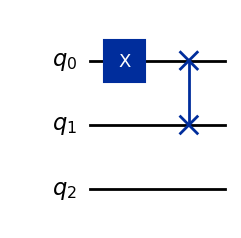

In [3]:
qc.draw('mpl')

In [4]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.quantum_info import Statevector

n = 3
reg = QuantumRegister(n, 'q')
qc  = QuantumCircuit(reg)

qc.x(reg[0])
qc.swap(reg[0], reg[1])

sv = Statevector.from_instruction(qc)
print(sv.data)
sv.draw('latex')


[0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


<IPython.core.display.Latex object>

### 量子フーリエ変換

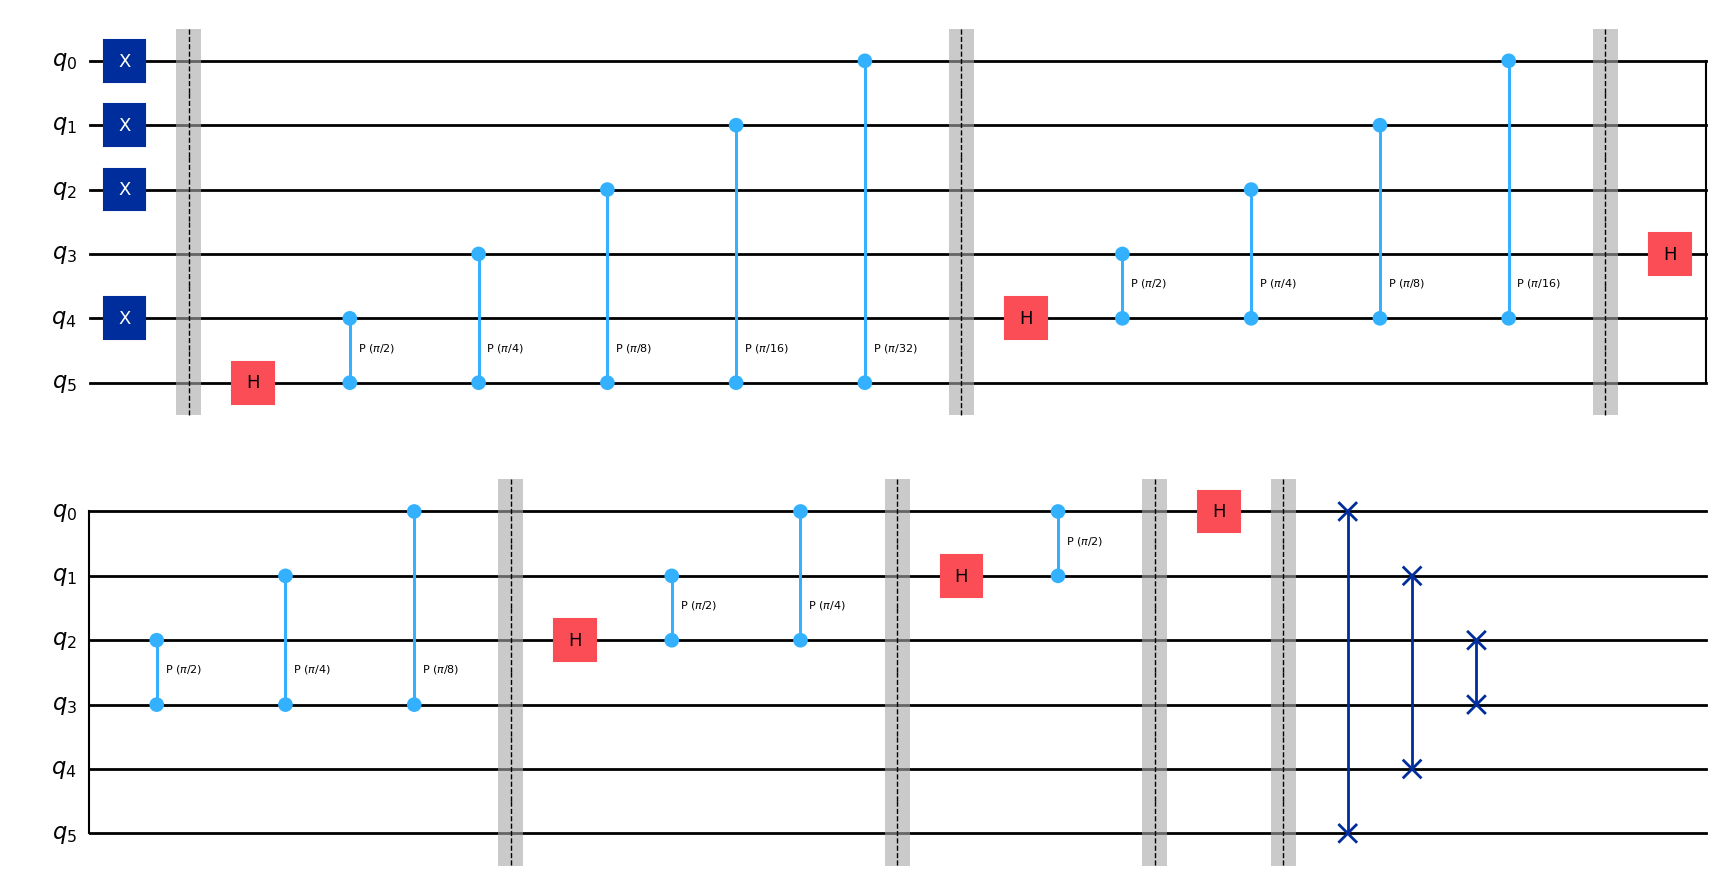

In [5]:
num_qubits = 6

circuit = QuantumCircuit(num_qubits)

# 具体的にするため、入力状態を|23>とする
j = 23

## jの２進数表現で値が1になっているビットに対してXを作用させる -> 状態|j>を作る

# まずjの２進数表現を得るために、unpackbitsを利用（他にもいろいろな方法がある）
# unpackbitsはuint8タイプのアレイを引数に取るので、jをその形に変換してから渡している
j_bits = np.unpackbits(np.asarray(j, dtype=np.uint8), bitorder='little')
# 次にj_bitsアレイのうち、ビットが立っているインデックスを得る
j_indices = np.nonzero(j_bits)[0]
# 最後にcircuit.x()
for idx in j_indices:
    circuit.x(idx)

## Alternative method
#for i in range(num_qubits):
#    if ((j >> i) & 1) == 1:
#        circuit.x(i)

circuit.barrier()

## ここからがQFT

# n-1から0まで標的ビットについてループ
for itarg in range(num_qubits - 1, -1, -1):
    # 標的ビットにアダマールゲートをかける
    circuit.h(itarg)
    # target - 1から0まで制御ビットについてループ
    for ictrl in range(itarg - 1, -1, -1):
        # 標的と制御ビットのインデックスに応じた角度で制御Pゲートをかける
        power = ictrl - itarg - 1 + num_qubits
        circuit.cp((2 ** power) * 2. * np.pi / (2 ** num_qubits), ictrl, itarg)

    # 回路図を見やすくするためにバリアを入れる
    circuit.barrier()

# 最後にビットの順番を反転させる
for i in range(num_qubits // 2):
    circuit.swap(i, num_qubits - 1 - i)

## ここまでがQFT

circuit.draw('mpl')

In [6]:
sqrt_2_to_n = 2 ** (num_qubits // 2)
amp_norm = (1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n)
phase_norm = (2 * np.pi / (2 ** num_qubits), r'\frac{2 \pi i}{%d}' % (2 ** num_qubits))
expr = statevector_expr(circuit, amp_norm=amp_norm, phase_norm=phase_norm)
Math(expr)

<IPython.core.display.Math object>

### 量子フーリエ変換による足し算

In [7]:
def setup_addition(circuit, reg1, reg2, reg3):
    # reg3にequal superpositionを生成
    # QuantumCircuitの1量子ビットゲートに対応するメソッド（circuit.hなど）に単一の量子ビットの代わりに
    # レジスタや量子ビットのリストを渡すと、含まれる全ての量子ビットに同じゲートをかけてくれる
    circuit.h(reg3)

    # 位相の単位（dphiの整数倍の位相をCPゲートでかけていく）
    dphi = 2. * np.pi / (2 ** reg3.size)

    # reg1とreg2それぞれの量子ビットで制御する
    for reg_ctrl in [reg1, reg2]:
        # 制御ビットに関するループ
        for ictrl, qctrl in enumerate(reg_ctrl):
            # reg3の標的ビットに関するループ
            for itarg, qtarg in enumerate(reg3):
                # C[P(phi)], phi = 2pi * 2^{ictrl} * 2^{itarg} / 2^{n3}
                circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)

    # 回路図を見やすくするためのバリア
    circuit.barrier()

    # Inverse QFT
    for j in range(reg3.size // 2):
        circuit.swap(reg3[j], reg3[-1 - j])

    for itarg in range(reg3.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1 + reg3.size
            circuit.cp(-dphi * (2 ** power), reg3[ictrl], reg3[itarg])

        circuit.h(reg3[itarg])

print('Defined function setup_addition')

Defined function setup_addition


n1=4, n2=4, n3=5


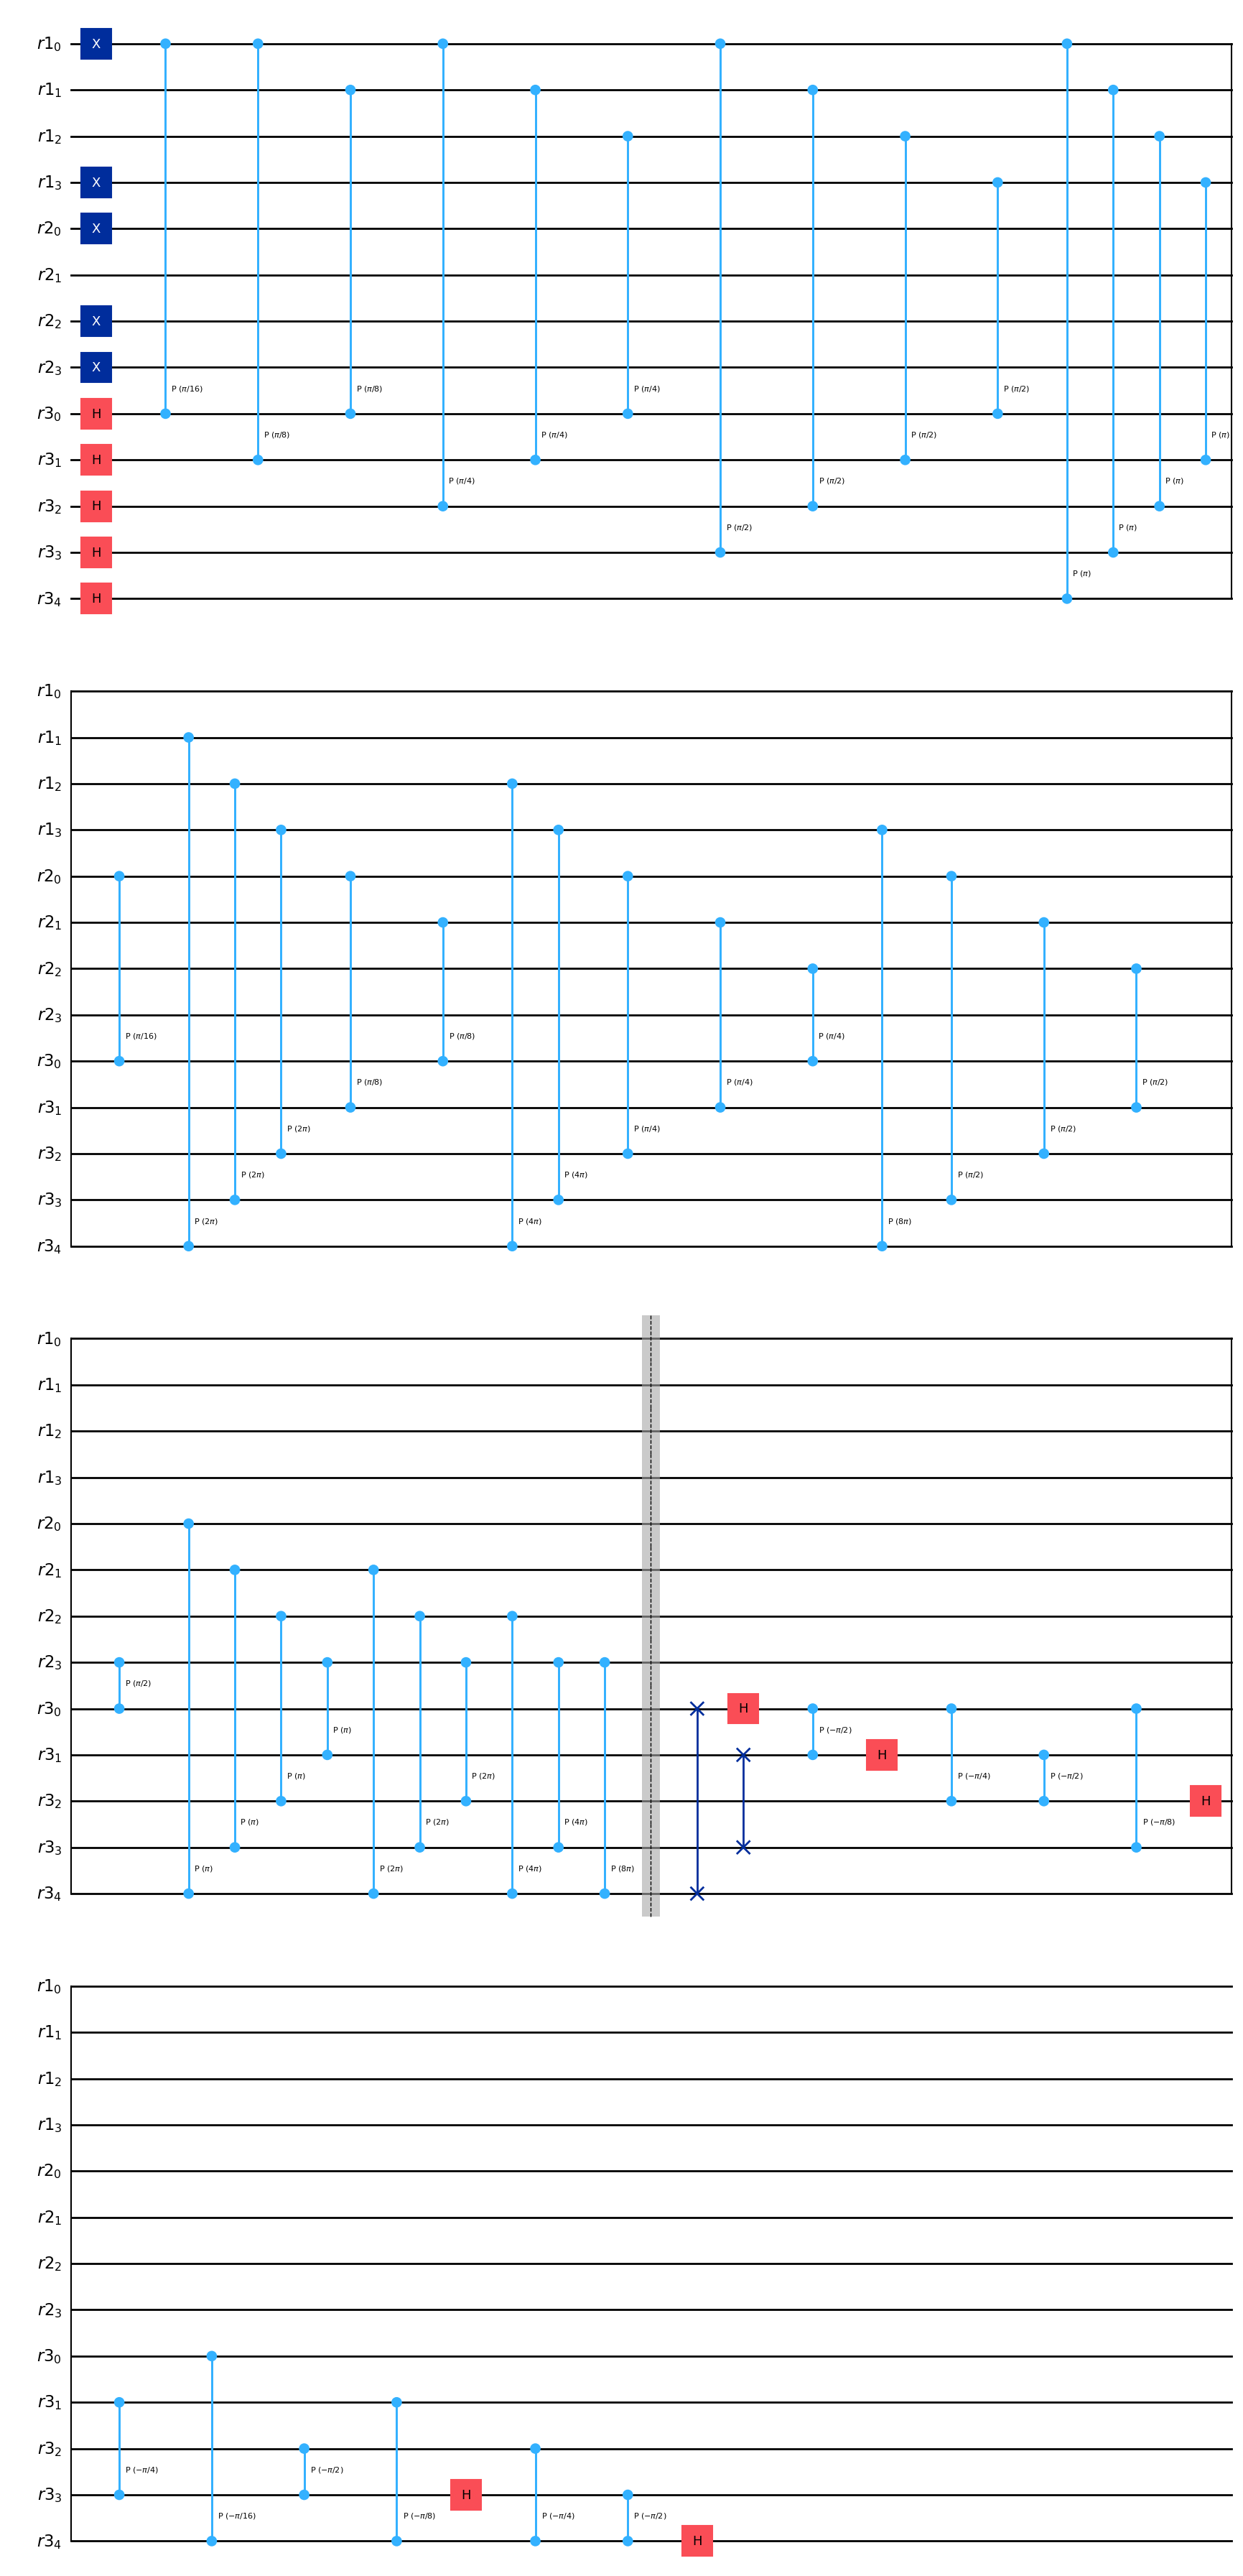

In [8]:
a = 9
b = 13

# 入力の値を二進数表現できる最小のビット数を計算
n1 = np.ceil(np.log2(a + 1)).astype(int)
n2 = np.ceil(np.log2(b + 1)).astype(int)
n3 = np.ceil(np.log2(a + b + 1)).astype(int)

print(f'n1={n1}, n2={n2}, n3={n3}')

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

# QuantumCircuitは量子ビット数の代わりにレジスタを渡しても作成できる
circuit = QuantumCircuit(reg1, reg2, reg3)

# reg1を|a>にする
a_bits = np.unpackbits(np.asarray(a, dtype=np.uint8), bitorder='little')
for idx in np.nonzero(a_bits)[0]:
    circuit.x(reg1[idx])

# reg2を|b>にする
b_bits = np.unpackbits(np.asarray(b, dtype=np.uint8), bitorder='little')
for idx in np.nonzero(b_bits)[0]:
    circuit.x(reg2[idx])

# 足し算ルーチンを呼ぶ
setup_addition(circuit, reg1, reg2, reg3)

# 回路図を確認
circuit.draw('mpl')

In [9]:
expr = statevector_expr(circuit, register_sizes=(n1, n2, n3))
Math(expr)

<IPython.core.display.Math object>

### 足し算の並列化

In [10]:
n1 = 4
n2 = 4
n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

circuit = QuantumCircuit(reg1, reg2, reg3)

# reg1とreg2をequal superpositionにする
circuit.h(reg1)
circuit.h(reg2)

setup_addition(circuit, reg1, reg2, reg3)

expr = statevector_expr(circuit, register_sizes=(n1, n2, n3), amp_norm=(1. / np.sqrt(2 ** (n1 + n2)), r'\frac{1}{\sqrt{2^{n_1 + n_2}}}'))
Math(expr)

<IPython.core.display.Math object>

### シミュレータでの実行

In [11]:
# 元の回路に測定を加える
circuit.measure_all()
circuit_original = circuit

# 効率化した回路（測定付き）
circuit_optimized = optimized_additions(n1, n2)
print('Constructed an optimized addition circuit')

Constructed an optimized addition circuit


In [12]:
print('Number of operations in the original circuit:', circuit_original.size())
print('Number of operations in the optimized circuit:', circuit_optimized.size())

Number of operations in the original circuit: 83
Number of operations in the optimized circuit: 331


##### トランスパイル回路と物理的回路

https://docs.quantum.ibm.com/api/qiskit/compiler

##### 回路の比較

In [13]:
# # 利用できるインスタンスが複数ある場合（Premium accessなど）はここで指定する
# # instance = 'hub-x/group-y/project-z'
# instance = None

# try:
#     service = QiskitRuntimeService(channel='ibm_quantum', instance=instance)
# except AccountNotFoundError:
#     service = QiskitRuntimeService(channel='ibm_quantum', token=os.getenv("IBM_QUANTUM_TOKEN"), instance=instance)

# backend = service.least_busy(min_num_qubits=13, filters=operational_backend())

# print(f'Using backend {backend.name}')

In [39]:
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap

# --- 1. 線形カップリングを作る ------------------------------------------
n_qubits = n1 + n2 + n3                     # 回路が使う総量子ビット数
chain_edges = [(i, i+1) for i in range(n_qubits - 1)]  # 0-1-2-… 鎖
coupling = CouplingMap(chain_edges)         # ① 鎖だけの結合グラフ

backend = AerSimulator(method="density_matrix")         # 好きなシミュレータでOK

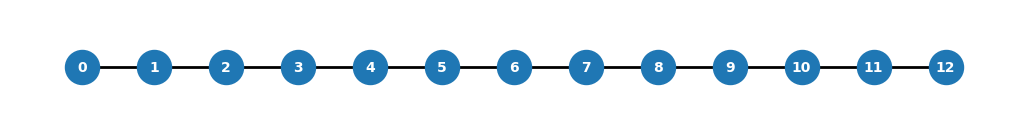

In [ ]:
import matplotlib.pyplot as plt

def draw_line_topology(n_qubits: int, ax=None):
    """Graphviz なしで“一次元鎖”トポロジーを可視化する簡易版"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(max(n_qubits, 6), 1.5))

    # 辺（線）
    for i in range(n_qubits - 1):
        ax.plot([i, i + 1], [0, 0], "k-", lw=2)

    # ノード（丸）
    ax.scatter(range(n_qubits), [0] * n_qubits, s=600, zorder=3)

    # ラベル
    for i in range(n_qubits):
        ax.text(i, 0, str(i), color="white", ha="center", va="center", weight="bold")

    ax.set_xlim(-1, n_qubits)
    ax.set_ylim(-1, 1)
    ax.axis("off")


# 使い方 -------------------------------------------------------------------
n_qubits = 13               # 好きな長さ
draw_line_topology(n_qubits)
plt.show()

In [ ]:
# 数珠繋ぎだとswapが大量に発生するので自分でswap最適化したほうが早い
# 13 qbitはすべてheavy-hexなので違いが出にくい(q = 5ならあるらしい)
# CouplingMapで，鎖しか許されない仮想デバイスを作成

def pick_entangling_gate(backend, transpiled_circ):
    """
    backend が BackendV2 なら target から、
    そうでなければ回路に現れたゲート一覧から
    2量子ビット基本ゲート名を 1 つ返す。
    """
    # -------- BackendV2: target から探す ----------
    if hasattr(backend, "target"):
        for op in backend.target.operations:
            if getattr(op, "num_qubits", None) == 2:
                return op.name

    # -------- BackendV1 / AerSimulator など -------
    twoq_candidates = ["cx", "cz", "ecr", "iswap", "swap"]
    for g in twoq_candidates:
        if g in transpiled_circ.count_ops():
            return g
    raise RuntimeError("2-qubit ゲートが見つかりません")

def count_2q(circ):
    """回路中の 2 量子ビットゲート総数を返す"""
    return sum(1 for instr, qargs, _ in circ.data if len(qargs) == 2)

In [ ]:
# オリジナルの回路をトランスパイルする。optimization_level=3は自動設定のうち、最も効率のいい回路を作る
print('Transpiling the original circuit with standard settings')
my_basis = ['rz', 'sx', 'x', 'cx']   # ② 3Qゲートを含まない基底
circuit_original_tr = transpile(circuit_original,
                                backend=backend,
                                coupling_map=coupling, # 追加
                                basis_gates=my_basis, # 追加
                                optimization_level=3)

# 効率化した回路をトランスパイルする。マシンのトポロジーに従い、最も合計エラー率の低い量子ビット列にマッピングする
print('Transpiling the optimized circuit with trivial mapping onto a chain of qubits')
# initial_layout = find_best_chain(backend, n1 + n2 + n3)
initial_layout = list(range(n_qubits))
circuit_optimized_tr = transpile(circuit_optimized,
                                 backend=backend,
                                 coupling_map=coupling, # 追加
                                 basis_gates=my_basis, # 追加
                                 routing_method='basic', initial_layout=initial_layout,
                                 optimization_level=3)

# count_opsは回路に含まれる基本ゲートの数を辞書として返す
# nops_orig = circuit_original_tr.count_ops()
# nops_opt = circuit_optimized_tr.count_ops()
orig_2q = count_2q(circuit_original_tr)
opt_2q  = count_2q(circuit_optimized_tr)

# バックエンドによって2量子ビット基本ゲートが異なるので、調べておく。ecrはCNOTゲートの要素
# entangling_gate = next(g.name for g in backend.gates if g.name in ['cz', 'ecr'])
entangling_gate = pick_entangling_gate(backend, circuit_original_tr)

# print(f'Number of operations in the original circuit: {circuit_original_tr.size()}')
# print(f'  Breakdown: N(Rz)={nops_orig["rz"]}, N(X)={nops_orig["x"]}, N(SX)={nops_orig["sx"]}, N(2Q)={nops_orig[entangling_gate]}')
# print(f'Number of operations in the optimized circuit: {circuit_optimized_tr.size()}')
# print(f'  Breakdown: N(Rz)={nops_opt["rz"]}, N(X)={nops_opt["x"]}, N(SX)={nops_opt["sx"]}, N(2Q)={nops_opt[entangling_gate]}')
print(f"Total  : {circuit_optimized_tr.size()/circuit_original_tr.size():.2%}")
# print(f"2-qubit: {nops_opt[entangling_gate]/nops_orig[entangling_gate]:.2%}")
print(f"2-qubit: {opt_2q / orig_2q:.2%}")

Transpiling the original circuit with standard settings
Transpiling the optimized circuit with trivial mapping onto a chain of qubits
Total  : 77.97%
2-qubit: 73.20%


/home/trinitrotorol/workspace/al22085/qiskit/qiskit_env/lib/python3.12/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(
/tmp/ipykernel_90108/1771395905.py:22: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  return sum(1 for instr, qargs, _ in circ.data if len(qargs) == 2)


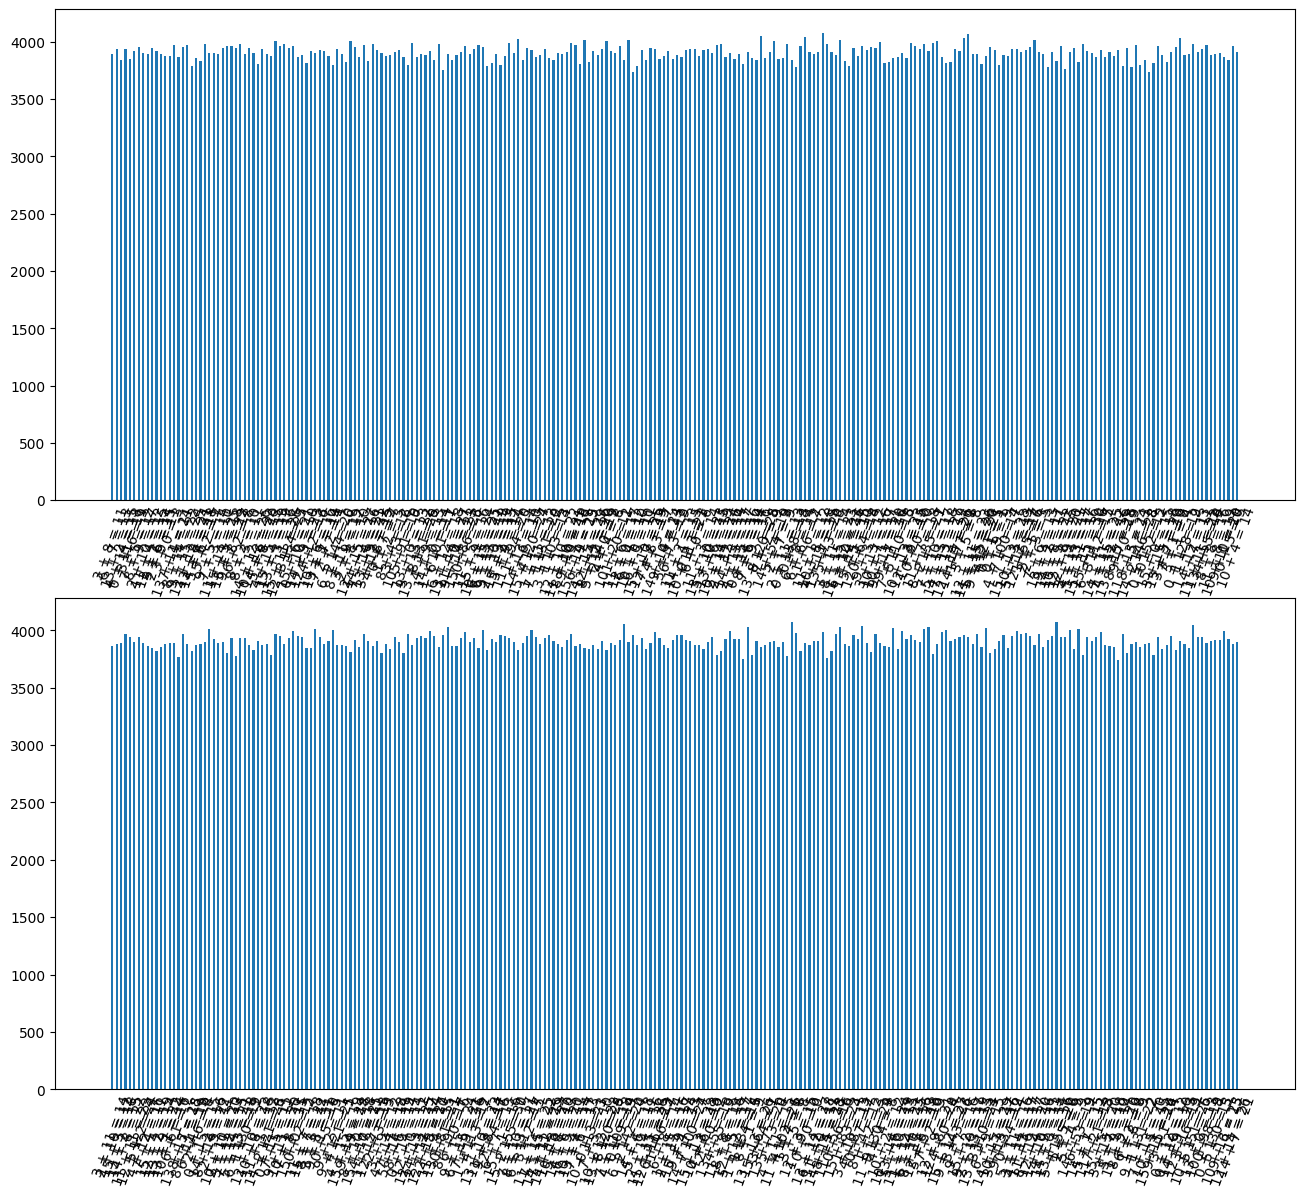

In [ ]:
simulator = AerSimulator()

shots = 1000000

job_original = simulator.run(circuit_original_tr, shots=shots)
counts_original = job_original.result().get_counts()

job_optimized = simulator.run(circuit_optimized_tr, shots=shots)
counts_optimized = job_optimized.result().get_counts()

def plot_counts(counts, n1, n2, ax):
    heights = []
    labels = []

    for key, value in counts.items():
        heights.append(value)

        # countsのキーはひとつなぎの二進数なので、出力, 入力2, 入力1の値が読み取れるように切り分ける
        # 4 + 4 桁なら
        #  00110 0101 0001 -> 6 = 5 + 1
        #  n3    n2   n1
        x1 = int(key[-n1:], 2) # last n1 digits
        x2 = int(key[-n1 - n2:-n1], 2) # next-to-last n2 digits
        x3 = int(key[:-n1 - n2], 2) # first n3 digits
        labels.append('{} + {} = {}'.format(x1, x2, x3))

    x = np.linspace(0., len(labels), len(labels), endpoint=False)

    # 棒グラフをプロット
    ax.bar(x, heights, width=0.5)

    # ビジュアルを調整
    ax.set_xticks(x - 0.2)
    ax.set_xticklabels(labels, rotation=70)
    ax.tick_params('x', length=0.)

# サブプロットが縦に二つ並んだフィギュアを作成
fig, (ax_original, ax_optimized) = plt.subplots(2, figsize=[16, 10])

# サブプロット1: counts_original
plot_counts(counts_original, n1, n2, ax_original)

# サブプロット2: counts_optimized
plot_counts(counts_optimized, n1, n2, ax_optimized)

fig.subplots_adjust(bottom=-0.2)

#### 図

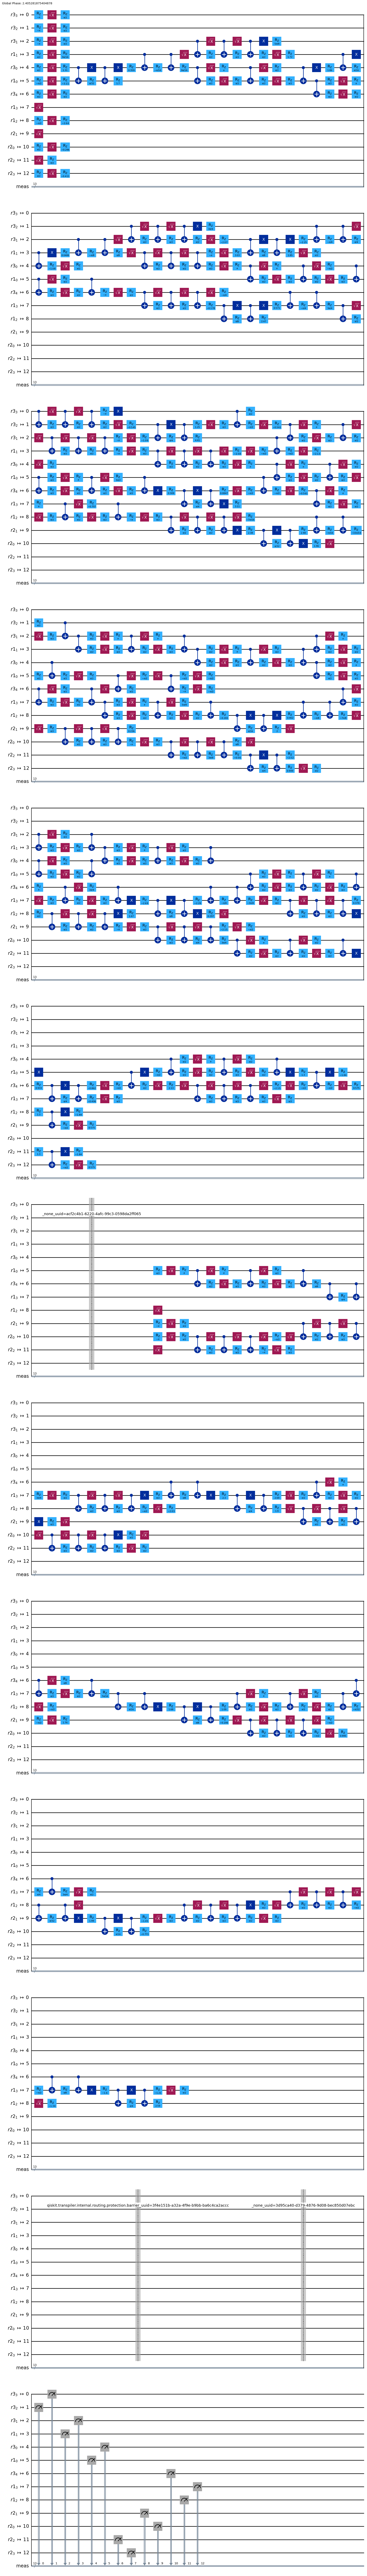

In [46]:
circuit_original_tr.draw('mpl')

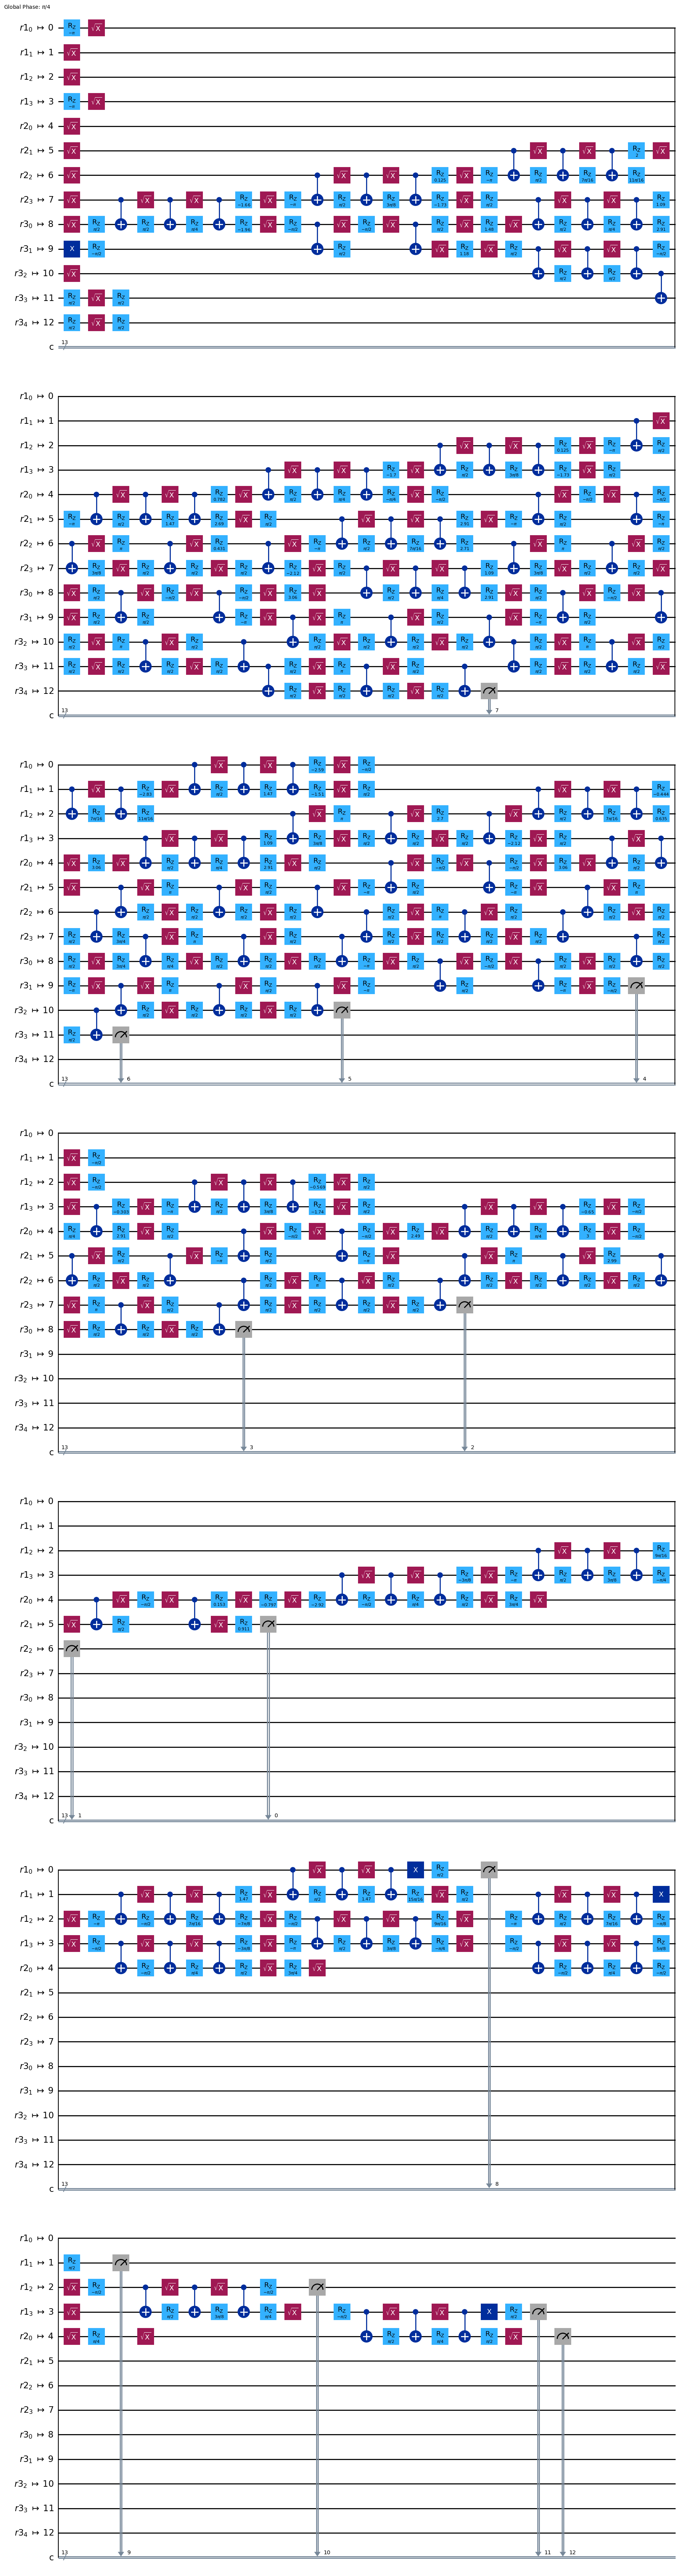

In [47]:
circuit_optimized_tr.draw('mpl')